In [6]:
import os
import cv2
import numpy as np
import seaborn as sns
# import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#### Preprocessing

In [7]:
Path = './leapGestRecog'
def LoadData(Path, img_height, img_width):
    Images = []
    Labels = []
    for subject_folder in os.listdir(Path):
        subject_path = os.path.join(Path, subject_folder)
        if os.path.isdir(subject_path):
            for gesture_folder in os.listdir(subject_path):
                gesture_path = os.path.join(subject_path, gesture_folder)
                if os.path.isdir(gesture_path):
                    for image_name in os.listdir(gesture_path):
                        image_path = os.path.join(gesture_path, image_name)
                        image = plt.imread(image_path)
                        if image is not None:
                            image = cv2.resize(image, (img_height, img_width))
                            if len(image.shape) == 2:  # Handle grayscale images
                                image = np.stack((image,) * 3, axis=-1)
                            Images.append(image)
                            Labels.append(gesture_folder)
    return np.array(Images), np.array(Labels)


ImgHeight, ImgWidth = 128, 128
Images, Labels = LoadData(Path, ImgHeight, ImgWidth)
NumChannels = 3
LabelEn = LabelEncoder()
EncodedLabels = LabelEn.fit_transform(Labels)
XTrain, XTest, YTrain, YTest = train_test_split(Images, EncodedLabels, test_size=0.2, random_state=42)


In [10]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare the data generators
train_generator = datagen.flow(XTrain, YTrain, batch_size=32)
test_generator = ImageDataGenerator(rescale=1.0/255.0).flow(XTest, YTest, batch_size=32)


#### Model

In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(ImgHeight, ImgWidth, NumChannels)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [12]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
500/500 [==============================] - 141s 279ms/step - loss: 2.3030 - accuracy: 0.1012 - val_loss: 2.3031 - val_accuracy: 0.0915
Epoch 2/50
500/500 [==============================] - 140s 279ms/step - loss: 2.3028 - accuracy: 0.0983 - val_loss: 2.3031 - val_accuracy: 0.0943
Epoch 3/50
500/500 [==============================] - 200s 400ms/step - loss: 2.3029 - accuracy: 0.1031 - val_loss: 2.3029 - val_accuracy: 0.0943
Epoch 4/50
500/500 [==============================] - 123s 246ms/step - loss: 2.3028 - accuracy: 0.0989 - val_loss: 2.3029 - val_accuracy: 0.0915
Epoch 5/50
500/500 [==============================] - 123s 245ms/step - loss: 2.3028 - accuracy: 0.0994 - val_loss: 2.3031 - val_accuracy: 0.0915
Epoch 6/50
500/500 [==============================] - 121s 242ms/step - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3030 - val_accuracy: 0.0943
Epoch 7/50
500/500 [==============================] - 123s 246ms/step - loss: 2.3028 - accuracy: 0.0978 - val_loss: 2.3030 -

#### Evaluating

In [13]:
model.load_weights('best_model.h5')
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

125/125 [==============================] - 5s 43ms/step - loss: 2.3029 - accuracy: 0.0943
Test Accuracy: 9.43%


#### Predicting

In [14]:
YPred = model.predict(test_generator)
YPredClass = np.argmax(YPred, axis=1)
print(classification_report(YTest, YPredClass, target_names=LabelEn.classes_))


125/125 [==============================] - 5s 43ms/step
               precision    recall  f1-score   support

      01_palm       0.00      0.00      0.00       417
         02_l       0.00      0.00      0.00       404
      03_fist       0.00      0.00      0.00       404
04_fist_moved       0.00      0.00      0.00       418
     05_thumb       0.09      1.00      0.17       377
     06_index       0.00      0.00      0.00       392
        07_ok       0.00      0.00      0.00       403
08_palm_moved       0.00      0.00      0.00       409
         09_c       0.00      0.00      0.00       410
      10_down       0.00      0.00      0.00       366

     accuracy                           0.09      4000
    macro avg       0.01      0.10      0.02      4000
 weighted avg       0.01      0.09      0.02      4000



c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\97156\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

#### Confusion Matrix

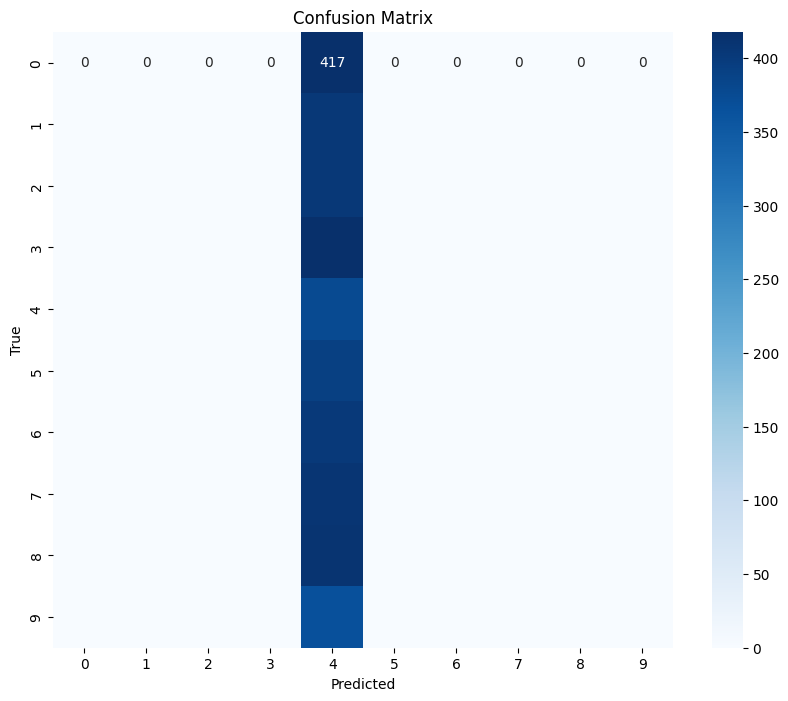

In [16]:
ConfMatrix = confusion_matrix(YTest, YPredClass)
plt.figure(figsize=(10, 8))
sns.heatmap(ConfMatrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()